### ***Importing Libraries*** 

In [173]:
import os
import cv2
import keras
from keras import layers
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAvgPool2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard, LambdaCallback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision ,Accuracy

import warnings
warnings.filterwarnings('ignore')

In [174]:
data_path = "/kaggle/input/arabic-letters/alphabet/"
batchSize = 32
IMG_DIM = 32
input_shape = (IMG_DIM,IMG_DIM,3)

In [175]:
# Helper Functions 
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def imshow(img, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()

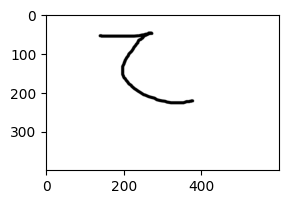

(400, 600, 3)

In [176]:
img_path = '/kaggle/input/arabic-letters/alphabet/ح/haa102.png'
img = imread(img_path)
imshow(img)
img.shape

In [177]:
class_dict = {
 0: 'أ',
 1: 'ب',
 2: 'ت',
 3: 'ث',
 4: 'ج',
 5: 'ح',
 6: 'خ',
 7: 'د',
 8: 'ذ',
 9: 'ر',
 10: 'ز',
 11: 'س',
 12: 'ش',
 13: 'ص',
 14: 'ض',
 15: 'ط',
 16: 'ظ',
 17: 'ع',
 18: 'غ',
 19: 'ف',
 20: 'ق',
 21: 'ك',
 22: 'ل',
 23: 'م',
 24: 'ن',
 25: 'ه',
 26: 'و',
 27: 'ي'}
label_dict = dict(map(lambda x: tuple(reversed(x)), class_dict.items()))
label_dict

{'أ': 0,
 'ب': 1,
 'ت': 2,
 'ث': 3,
 'ج': 4,
 'ح': 5,
 'خ': 6,
 'د': 7,
 'ذ': 8,
 'ر': 9,
 'ز': 10,
 'س': 11,
 'ش': 12,
 'ص': 13,
 'ض': 14,
 'ط': 15,
 'ظ': 16,
 'ع': 17,
 'غ': 18,
 'ف': 19,
 'ق': 20,
 'ك': 21,
 'ل': 22,
 'م': 23,
 'ن': 24,
 'ه': 25,
 'و': 26,
 'ي': 27}

### ***Create DataFrame***

In [178]:
def create_dataframe(data_path):
    image_paths = []
    image_outputs = []
    for c, output in label_dict.items():
        folder_path = os.path.join(data_path, c)
        for f in os.listdir(folder_path):
            f_path = os.path.join(folder_path, f)
            if f_path.lower().endswith('.png'):
                image_paths.append(f_path)
                image_outputs.append(class_dict[output])
    df = pd.DataFrame({
        'images': image_paths,
        'labels': image_outputs
    })
    return df

In [179]:
DATA_PATH = '/kaggle/input/arabic-letters/alphabet'
df = create_dataframe(os.path.join(DATA_PATH))
df

,images,labels
0,/kaggle/input/arabic-letters/alphabet/أ/aliph...,أ
1,/kaggle/input/arabic-letters/alphabet/أ/aliph...,أ
2,/kaggle/input/arabic-letters/alphabet/أ/aliph...,أ
3,/kaggle/input/arabic-letters/alphabet/أ/aliph...,أ
4,/kaggle/input/arabic-letters/alphabet/أ/aliph...,أ
...,...,...
5740,/kaggle/input/arabic-letters/alphabet/ي/42.png,ي
5741,/kaggle/input/arabic-letters/alphabet/ي/y106.png,ي
5742,/kaggle/input/arabic-letters/alphabet/ي/y97.png,ي
5743,/kaggle/input/arabic-letters/alphabet/ي/y113.png,ي


In [180]:
# Split the data
train_files, test_files = train_test_split(df, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)

In [181]:
train_files

,images,labels
3734,/kaggle/input/arabic-letters/alphabet/غ/gha109...,غ
5201,/kaggle/input/arabic-letters/alphabet/ه/h186.png,ه
2562,/kaggle/input/arabic-letters/alphabet/ص/ss36.png,ص
3930,/kaggle/input/arabic-letters/alphabet/ف/f50.png,ف
660,/kaggle/input/arabic-letters/alphabet/ث/tha243...,ث
...,...,...
1282,/kaggle/input/arabic-letters/alphabet/خ/kha52.png,خ
5520,/kaggle/input/arabic-letters/alphabet/و/w110.png,و
3963,/kaggle/input/arabic-letters/alphabet/ف/f72.png,ف
3086,/kaggle/input/arabic-letters/alphabet/ض/daad27...,ض


In [182]:
# Ensure labels are strings if they are not already
train_files['labels'] = train_files['labels'].astype(str)
test_files['labels'] = test_files['labels'].astype(str)
val_files['labels'] = val_files['labels'].astype(str)

In [183]:
train_gen = ImageDataGenerator(rescale = 1.0/255)#,preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
test_gen = ImageDataGenerator(rescale = 1.0/255)#,preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
val_gen = ImageDataGenerator(rescale = 1.0/255)#,preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

In [184]:
x_y_train = train_gen.flow_from_dataframe(dataframe=train_files,target_size=(IMG_DIM,IMG_DIM),batch_size=batchSize,x_col='images',y_col='labels')
x_y_test = test_gen.flow_from_dataframe(dataframe=test_files,target_size=(IMG_DIM,IMG_DIM),batch_size=batchSize,x_col='images',y_col='labels',shuffle=False)
x_y_val = val_gen.flow_from_dataframe(dataframe=val_files,target_size=(IMG_DIM,IMG_DIM),batch_size=batchSize,x_col='images',y_col='labels')

Found 3447 validated image filenames belonging to 28 classes.
Found 1149 validated image filenames belonging to 28 classes.
Found 1149 validated image filenames belonging to 28 classes.


In [185]:
labels = x_y_train.class_indices
labels_list = []
for label in labels:
    labels_list.append(label)
    label_dict = {
 0: 'أ',
 1: 'ب',
 2: 'ت',
 3: 'ث',
 4: 'ج',
 5: 'ح',
 6: 'خ',
 7: 'د',
 8: 'ذ',
 9: 'ر',
 10: 'ز',
 11: 'س',
 12: 'ش',
 13: 'ص',
 14: 'ض',
 15: 'ط',
 16: 'ظ',
 17: 'ع',
 18: 'غ',
 19: 'ف',
 20: 'ق',
 21: 'ك',
 22: 'ل',
 23: 'م',
 24: 'ن',
 25: 'ه',
 26: 'و',
 27: 'ي'}
print(label_dict)

{0: 'أ', 1: 'ب', 2: 'ت', 3: 'ث', 4: 'ج', 5: 'ح', 6: 'خ', 7: 'د', 8: 'ذ', 9: 'ر', 10: 'ز', 11: 'س', 12: 'ش', 13: 'ص', 14: 'ض', 15: 'ط', 16: 'ظ', 17: 'ع', 18: 'غ', 19: 'ف', 20: 'ق', 21: 'ك', 22: 'ل', 23: 'م', 24: 'ن', 25: 'ه', 26: 'و', 27: 'ي'}


In [186]:
for image_batch, labels_batch in x_y_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 32, 32, 3)
(32, 28)


In [187]:
# Define callbacks
def getCallbacks(model_name):
    callbacks = [
        ModelCheckpoint(filepath=f'model.{model_name}.h5', monitor='val_loss', save_best_only=True,verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    ]
    return callbacks


# ***CNN Model*** 🚀

In [188]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3),padding= "same", activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3),padding= "same", activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3),padding= "same", activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=28, activation='softmax'))
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 16, 16, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 4, 4, 64)         

In [189]:
history = cnn_model.fit(x_y_train,
                        validation_data= x_y_val,
                        epochs= 20,
                        verbose= 2,batch_size=batchSize,
                        callbacks= getCallbacks('CNN')) 

Epoch 1/20

Epoch 1: val_loss improved from inf to 2.45754, saving model to model.CNN.h5
108/108 - 14s - loss: 3.0995 - accuracy: 0.1082 - val_loss: 2.4575 - val_accuracy: 0.2463 - lr: 0.0010 - 14s/epoch - 127ms/step
Epoch 2/20

Epoch 2: val_loss improved from 2.45754 to 1.29485, saving model to model.CNN.h5
108/108 - 11s - loss: 1.7967 - accuracy: 0.4285 - val_loss: 1.2949 - val_accuracy: 0.5927 - lr: 0.0010 - 11s/epoch - 104ms/step
Epoch 3/20

Epoch 3: val_loss improved from 1.29485 to 0.97842, saving model to model.CNN.h5
108/108 - 11s - loss: 1.0613 - accuracy: 0.6609 - val_loss: 0.9784 - val_accuracy: 0.6701 - lr: 0.0010 - 11s/epoch - 103ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.97842 to 0.80179, saving model to model.CNN.h5
108/108 - 11s - loss: 0.7597 - accuracy: 0.7392 - val_loss: 0.8018 - val_accuracy: 0.7372 - lr: 0.0010 - 11s/epoch - 105ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 0.80179
108/108 - 11s - loss: 0.5970 - accuracy: 0.7862 - val_loss: 0

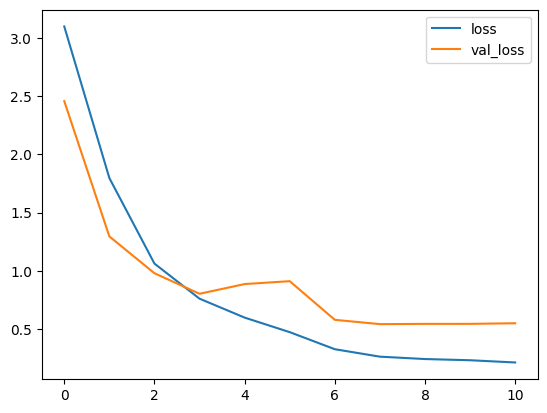

In [190]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

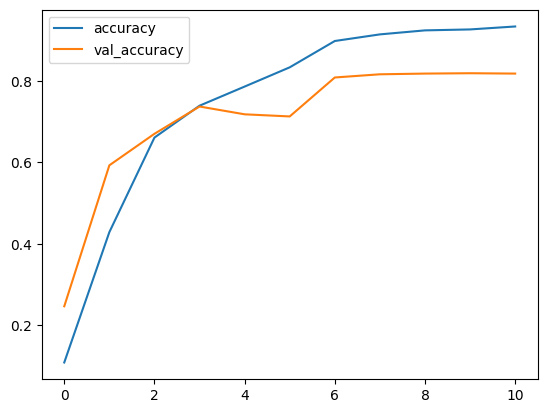

In [191]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [192]:
test_loss, test_accuracy = cnn_model.evaluate(x_y_test)

36/36 [==============================] - 3s 83ms/step - loss: 0.6442 - accuracy: 0.7990


In [193]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = cnn_model.predict(x_y_test)
pred = list(map(lambda x: label_dict[np.argmax(x)], prediction))
y_test = list(map(lambda x: label_dict[x],x_y_test.classes))

36/36 [==============================] - 3s 78ms/step


In [194]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

          أ       0.88      1.00      0.94        46
           ب       0.87      0.60      0.71        45
           ت       0.79      0.79      0.79        48
           ث       0.74      0.81      0.78        32
           ج       0.71      0.65      0.68        37
           ح       0.65      0.72      0.68        39
           خ       0.80      0.78      0.79        45
           د       0.80      0.78      0.79        50
           ذ       0.79      0.77      0.78        39
           ر       0.88      0.86      0.87        43
           ز       0.83      0.76      0.79        25
           س       0.86      0.86      0.86        44
           ش       0.73      0.71      0.72        34
           ص       0.86      0.68      0.76        56
           ض       0.62      0.86      0.72        44
           ط       0.69      0.73      0.71        45
           ظ       0.70      0.62      0.

# ***DenseNet121*** 🤖

In [195]:
train_gen_dens = ImageDataGenerator(rescale = 1.0/255,preprocessing_function=tf.keras.applications.densenet.preprocess_input)
test_gen_dens = ImageDataGenerator(rescale = 1.0/255,preprocessing_function=tf.keras.applications.densenet.preprocess_input)
val_gen_dens = ImageDataGenerator(rescale = 1.0/255,preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [196]:
x_y_train_dens = train_gen_dens.flow_from_dataframe(dataframe=train_files,target_size=(IMG_DIM,IMG_DIM),batch_size=batchSize,x_col='images',y_col='labels')
x_y_test_dens = test_gen_dens.flow_from_dataframe(dataframe=test_files,target_size=(IMG_DIM,IMG_DIM),batch_size=batchSize,x_col='images',y_col='labels',shuffle=False)
x_y_val_dens = val_gen_dens.flow_from_dataframe(dataframe=val_files,target_size=(IMG_DIM,IMG_DIM),batch_size=batchSize,x_col='images',y_col='labels')

Found 3447 validated image filenames belonging to 28 classes.
Found 1149 validated image filenames belonging to 28 classes.
Found 1149 validated image filenames belonging to 28 classes.


In [197]:
DenseNet121_model = keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)
DenseNet121_model.trainable = True
x = DenseNet121_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
DenseNet121_pred = keras.layers.Dense(28,activation='softmax',name='final')(x)
modelDenseNet121 = keras.models.Model(DenseNet121_model.input,DenseNet121_pred)

In [198]:
modelDenseNet121.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
modelDenseNet121.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 38, 38, 3)            0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 16, 16, 64)           9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1/conv[0][0]']    

In [199]:
history2 = modelDenseNet121.fit(x_y_train,
                                validation_data= x_y_val,
                                epochs= 20,
                                verbose= 2,
                                callbacks=getCallbacks('DenseNet121'))

Epoch 1/20

Epoch 1: val_loss improved from inf to 2.64923, saving model to model.DenseNet121.h5
108/108 - 76s - loss: 2.0465 - accuracy: 0.4294 - val_loss: 2.6492 - val_accuracy: 0.4595 - lr: 0.0010 - 76s/epoch - 704ms/step
Epoch 2/20

Epoch 2: val_loss improved from 2.64923 to 2.13630, saving model to model.DenseNet121.h5
108/108 - 13s - loss: 1.1172 - accuracy: 0.6577 - val_loss: 2.1363 - val_accuracy: 0.4813 - lr: 0.0010 - 13s/epoch - 123ms/step
Epoch 3/20

Epoch 3: val_loss improved from 2.13630 to 1.77336, saving model to model.DenseNet121.h5
108/108 - 14s - loss: 1.0076 - accuracy: 0.7035 - val_loss: 1.7734 - val_accuracy: 0.6693 - lr: 0.0010 - 14s/epoch - 126ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 1.77336
108/108 - 12s - loss: 0.7725 - accuracy: 0.7482 - val_loss: 4.1437 - val_accuracy: 0.5840 - lr: 0.0010 - 12s/epoch - 111ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 1.77336
108/108 - 12s - loss: 0.5658 - accuracy: 0.8146 - val_loss: 2.3685 - va

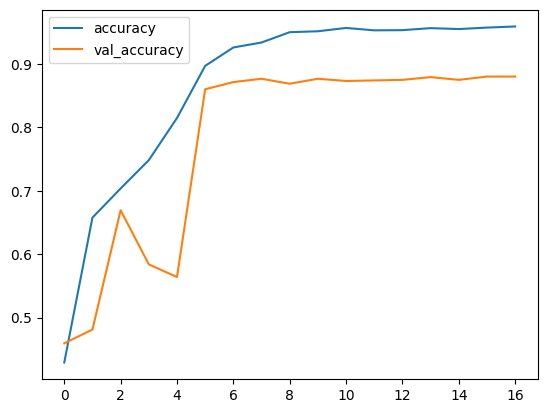

In [200]:
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

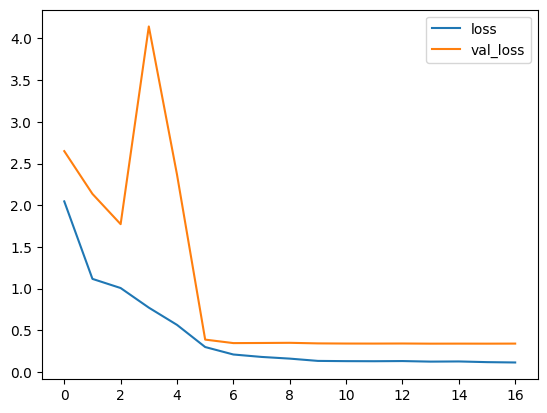

In [201]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [202]:
test_loss, test_accuracy = modelDenseNet121.evaluate(x_y_test)

36/36 [==============================] - 3s 82ms/step - loss: 0.3286 - accuracy: 0.8738


In [203]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = modelDenseNet121.predict(x_y_test)
pred = list(map(lambda x: label_dict[np.argmax(x)], prediction))
y_test = list(map(lambda x: label_dict[x],x_y_test.classes))

36/36 [==============================] - 5s 77ms/step


In [204]:
print('\t\tThe Model DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

		The Model DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

          أ       0.96      1.00      0.98        46
           ب       0.95      0.87      0.91        45
           ت       0.87      0.81      0.84        48
           ث       0.79      0.84      0.82        32
           ج       0.86      0.84      0.85        37
           ح       0.83      0.87      0.85        39
           خ       0.95      0.91      0.93        45
           د       0.79      0.90      0.84        50
           ذ       0.82      0.69      0.75        39
           ر       0.89      0.95      0.92        43
           ز       0.92      0.88      0.90        25
           س       0.90      0.98      0.93        44
           ش       0.86      0.74      0.79        34
           ص       0.92      0.86      0.89        56
           ض       0.75      0.91      0.82        44
           ط       0.67      0.71      0.69        45
           ظ       0.69      0.60 

# ***Testing*** ✌️

In [206]:
model_name = 'CNN' # CNN or DenseNet121

# Computer Vision - Low level techniques
def load_model():
    model_path = f'/kaggle/working/model.{model_name}.h5'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            if model_name == 'DenseNet121':
                gray = tf.keras.applications.densenet.preprocess_input(gray)
            
            predicted = label_dict[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    imshow(image)
    return ''.join(chars[:-1])

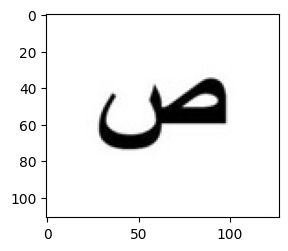

1/1 [==============================] - 0s 80ms/step
predicted:  ص


In [216]:
# Testing
test_path = '/kaggle/input/test-data/.png'
img = imread(test_path)
imshow(img)

model = load_model()
test_img_resized = cv2.resize(img, (32, 32))
test_img_array = np.expand_dims(test_img_resized, axis=0)

pred = model.predict(test_img_array)
print("predicted: ",label_dict[np.argmax(pred)])

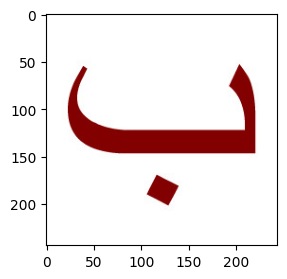

1/1 [==============================] - 0s 80ms/step
predicted:  ب


In [217]:
# Testing 
test_path = '/kaggle/input/testing-image/.jpg'
img = imread(test_path)
imshow(img)

model = load_model()
test_img_resized = cv2.resize(img, (32, 32))
test_img_array = np.expand_dims(test_img_resized, axis=0)

pred = model.predict(test_img_array)
print("predicted: ",label_dict[np.argmax(pred)])

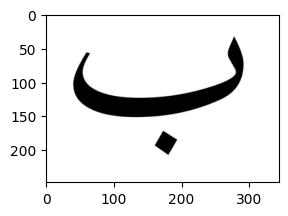

1/1 [==============================] - 0s 102ms/step
predicted:  ب


In [218]:
# Testing 
test_path = '/kaggle/input/testing-image/.png'
img = imread(test_path)
imshow(img)

model = load_model()
test_img_resized = cv2.resize(img, (32, 32))
test_img_array = np.expand_dims(test_img_resized, axis=0)

pred = model.predict(test_img_array)
print("predicted: ",label_dict[np.argmax(pred)])